In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle

In [11]:
paths = [
    "Data/Bengaluru_House_Data.csv"
]

df = pd.read_csv(paths[0])
df.head(), df.shape


(              area_type   availability                  location       size  \
 0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
 1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
 2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
 3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
 4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   
 
    society total_sqft  bath  balcony   price  
 0  Coomee        1056   2.0      1.0   39.07  
 1  Theanmp       2600   5.0      3.0  120.00  
 2      NaN       1440   2.0      3.0   62.00  
 3  Soiewre       1521   3.0      1.0   95.00  
 4      NaN       1200   2.0      1.0   51.00  ,
 (13320, 9))

In [13]:
import os

file_path = "Data/Bengaluru_House_Data.csv"

if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does NOT exist. Check folder name or file name.")


The file 'Data/Bengaluru_House_Data.csv' exists.


In [15]:
# info
print(df.columns)
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())

# basic stats for numeric-ish columns
display(df.describe(include='all').T)


Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB
None

Missing values per column:
 area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dty

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
area_type,13320,4,Super built-up Area,8790,NaN,NaN,NaN,NaN,NaN,NaN,NaN
availability,13320,81,Ready To Move,10581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,13319,1305,Whitefield,540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
size,13304,31,2 BHK,5199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
society,7818,2688,GrrvaGr,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_sqft,13320,2117,1200,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bath,13247.0,NaN,NaN,NaN,2.69261,1.341458,1.0,2.0,2.0,3.0,40.0
balcony,12711.0,NaN,NaN,NaN,1.584376,0.817263,0.0,1.0,2.0,2.0,3.0
price,13320.0,NaN,NaN,NaN,112.565627,148.971674,8.0,50.0,72.0,120.0,3600.0


In [31]:
# drop unnecessary columns
cols_to_drop = ['area_type', 'availability', 'society', 'balcony']

for c in cols_to_drop:
    if c in df.columns:
        df = df.drop(c, axis=1)

# drop rows with nulls in essential columns
df = df.dropna(subset=['location', 'size', 'total_sqft', 'bath', 'price'])

df.shape



(12344, 7)

In [32]:
import numpy as np

X = df.drop("price", axis=1)
y = df["price"]

# log-transform target
y_log = np.log1p(y)


In [37]:
# extract bhk from "size" e.g., "2 BHK" -> 2
def extract_bhk(x):
    try:
        return int(str(x).split()[0])
    except:
        return None

df['bhk'] = df['size'].apply(extract_bhk)

# convert total_sqft; handle ranges "1200-1250" -> average
def convert_sqft(x):
    try:
        x = str(x).strip()
        if '-' in x:
            low, high = x.split('-')
            return (float(low) + float(high)) / 2.0
        return float(x)
    except:
        import re
        nums = re.findall(r"\d+\.?\d*", str(x))
        return float(nums[0]) if nums else np.nan

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)

# remove invalid rows
df = df.dropna(subset=['total_sqft', 'bhk'])

# enforce correct types
df['bhk'] = df['bhk'].astype(int)
df['total_sqft'] = df['total_sqft'].astype(float)



In [38]:
# price per sqft (price is in lacs -> convert to price per sqft in lacs/sqft)
df['price_per_sqft'] = (df['price'] * 100000) / df['total_sqft']  # price in rupees per sqft

# trim whitespace in location
df['location'] = df['location'].str.strip()

# collapse rare locations to 'other'
location_counts = df['location'].value_counts()
rare_locs = location_counts[location_counts <= 10].index
df['location'] = df['location'].apply(lambda x: 'other' if x in rare_locs else x)

# remove unrealistic entries: very low sqft per bhk (say < 250 sqft per bhk)
df = df[df['total_sqft'] / df['bhk'] >= 250]

# remove price_per_sqft extreme outliers using Z-score or quantiles
q1 = df['price_per_sqft'].quantile(0.01)
q99 = df['price_per_sqft'].quantile(0.99)
df = df[(df['price_per_sqft'] >= q1) & (df['price_per_sqft'] <= q99)]

df.shape


(12097, 7)

In [39]:
df = df.drop(columns=['price_per_sqft'])


In [40]:
X = df[['location', 'total_sqft', 'bath', 'bhk']]
y = df['price']
y_log = np.log1p(y)



In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape)


(9875, 6) (2469, 6)


In [21]:
# column transformer: OneHot for location, passthrough others
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ('loc', ohe, ['location'])
], remainder='passthrough')  # remainder will keep total_sqft, bath, bhk

# Optionally scale numeric columns (if using models that benefit from scaling)
# We'll scale after one-hot via Pipeline when needed


In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['location']
numeric_features = ['total_sqft', 'bath', 'bhk']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)


Cross-validation for best model (example: RandomForest)

In [23]:
best_model = RandomForestRegressor(n_estimators=200, random_state=42)
pipe_best = Pipeline([('pre', preprocessor), ('model', best_model)])
# cross-val (5-fold) on training set
cv_scores = cross_val_score(pipe_best, X_train, y_train, cv=5, scoring='r2')
print("RF CV R2 scores:", cv_scores)
print("Mean CV R2:", cv_scores.mean())
# fit full pipeline
pipe_best.fit(X_train, y_train)
preds_best = pipe_best.predict(X_test)
print("Test R2:", r2_score(y_test, preds_best))
print("Test MAE:", mean_absolute_error(y_test, preds_best))


RF CV R2 scores: [0.76505048 0.73701227 0.74685813 0.76443392 0.58480018]
Mean CV R2: 0.7196309975955619
Test R2: 0.6695227069337641
Test MAE: 27.516801029648835


Save the final pipeline model

In [25]:
import pickle
from pathlib import Path

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

model_path = MODEL_DIR / "house_price_pipeline.pkl"

with open(model_path, "wb") as f:
    pickle.dump(pipe_best, f)

print("Model saved to:", model_path)



Model saved to: models\house_price_pipeline.pkl


Utility: price prediction function (example)

In [26]:
# load the saved model (to demonstrate usage)
import pickle
pipe = pickle.load(open(model_filename, 'rb'))

def predict_house_price(location, total_sqft, bath, bhk):
    loc = location.strip()
    # if this location wasn't seen often, use 'other'
    if loc not in df['location'].unique():
        loc = 'other'
    sample = pd.DataFrame([[loc, total_sqft, bath, bhk]], columns=['location','total_sqft','bath','bhk'])
    pred_lakhs = pipe.predict(sample)[0]   # prediction in lakhs
    return pred_lakhs

# example prediction
print("Predicted price (in lakhs):", predict_house_price('Indira Nagar', 1200, 2, 2))


Predicted price (in lakhs): 92.67420952380951


Diagnostics & Visualizations

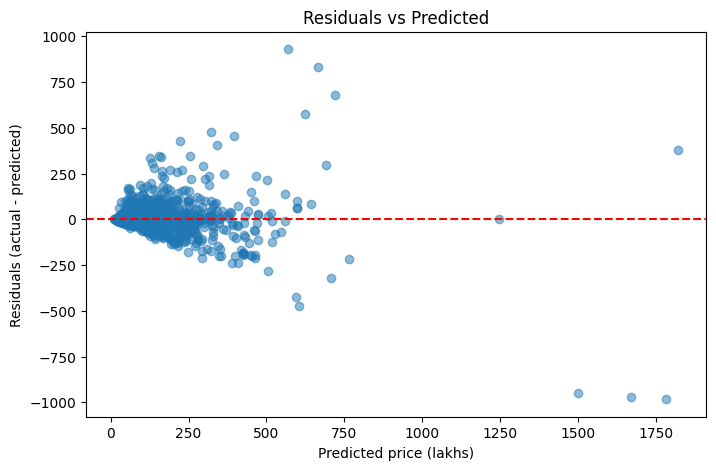

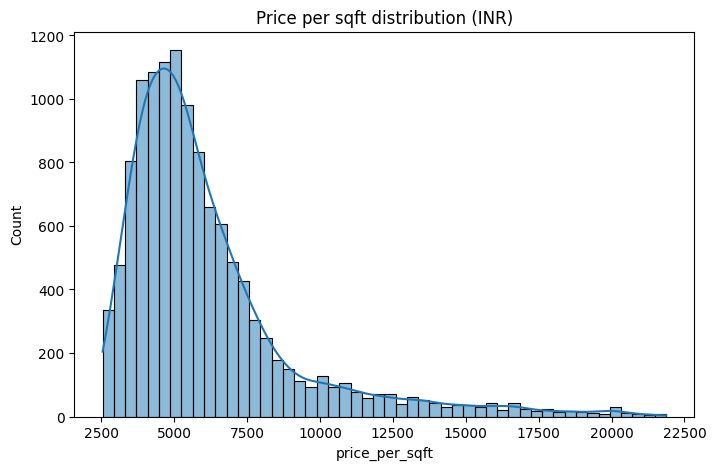

In [27]:
# residual plot for the test set
y_pred = pipe_best.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted price (lakhs)")
plt.ylabel("Residuals (actual - predicted)")
plt.title("Residuals vs Predicted")
plt.show()

# distribution of price_per_sqft
plt.figure(figsize=(8,5))
sns.histplot(df['price_per_sqft'], bins=50, kde=True)
plt.title("Price per sqft distribution (INR)")
plt.show()


Hyperparameter tuning example with GridSearch (RandomForest)

In [28]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

pipe_for_gs = Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(random_state=42))])
gs = GridSearchCV(pipe_for_gs, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV R2:", gs.best_score_)
best = gs.best_estimator_
print("Test R2 with best estimator:", r2_score(y_test, best.predict(X_test)))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV R2: 0.7155434652792957
Test R2 with best estimator: 0.6733938644411158
